Iniciando entrenamiento - 2024-12-01 22:28:51
Configuración del entrenamiento:
Batch size: 128
Epochs: 400
Learning rate: 0.1
Weight decay: 1e-05
Data augmentation: True
GPU disponible: True
--------------------------------------------------

Arquitectura del modelo:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)

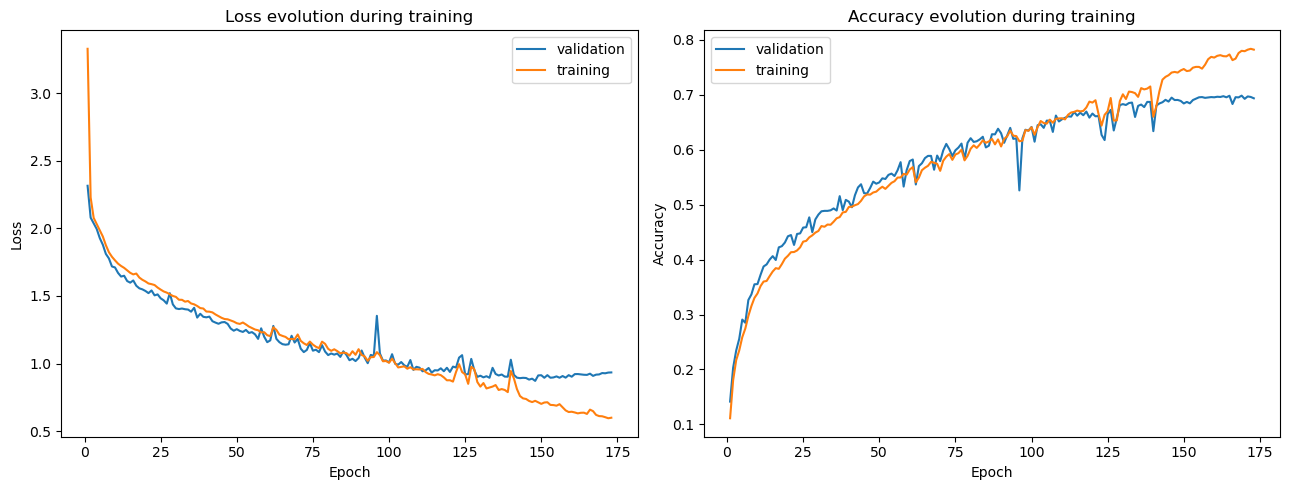

Iniciando entrenamiento - 2024-12-02 00:15:55
Configuración del entrenamiento:
Batch size: 128
Epochs: 400
Learning rate: 0.1
Weight decay: 0.001
Data augmentation: True
GPU disponible: True
--------------------------------------------------

Arquitectura del modelo:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)

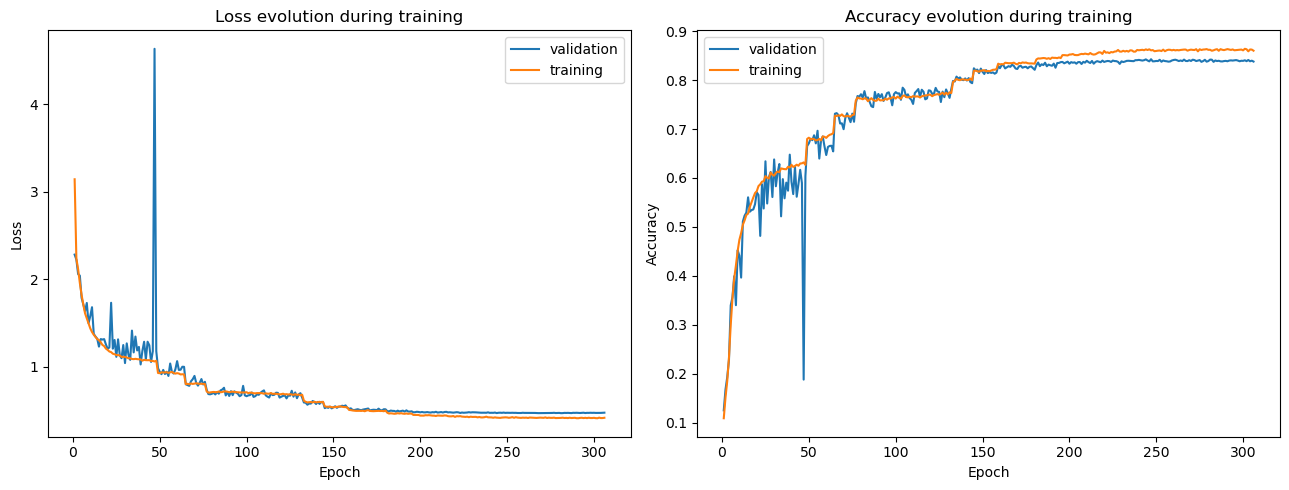

In [2]:
import os
import time
import torch
import numpy as np
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from eff import _efficientnet, _efficientnet_conf
import sys
from datetime import datetime

class Logger:
    def __init__(self, filename):
        self.terminal = sys.stdout
        self.log = open(filename, 'a', encoding='utf-8')
        
    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)
        self.log.flush()
        
    def flush(self):
        self.terminal.flush()
        self.log.flush()


# Transformaciones para entrenamiento y validación
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),  # Recorte aleatorio después del padding
    torchvision.transforms.RandomHorizontalFlip(),      # Volteo horizontal aleatorio
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Cargar datasets CIFAR-10 con transformaciones
train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=False,
    transform=train_transform  # Se aplica data augmentation aquí
)

test_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=False,
    download=False,
    transform=val_test_transform  # Solo normalización para testing
)

# Dividir dataset de entrenamiento y validación
train_cifar10, _ = torch.utils.data.random_split(train_cifar10, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_cifar10 = torch.utils.data.random_split(
    torchvision.datasets.CIFAR10(root="./cifar10", train=True, transform=val_test_transform),
    [45000, 5000], generator=torch.Generator().manual_seed(42)
)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def show_gradients_EfficientNet(model, epoch):
    # Crear directorio para los gradientes si no existe
    gradients_dir = os.path.join(checkpoint_dir, 'gradients')
    epoch_dir = os.path.join(gradients_dir, f'epoch_{epoch}')
    os.makedirs(epoch_dir, exist_ok=True)

    layers_to_show = ['features.0.0.weight', 'features.5.0.block.0.0.weight', 'classifier.1.weight']
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_show) and param.requires_grad and param.grad is not None:
            grad = param.grad.cpu().numpy()
            print(f"Gradientes para {name}: min={grad.min()}, max={grad.max()}, mean={grad.mean()}, std={grad.std()}")
            
            plt.figure(figsize=(8, 6))
            plt.hist(grad.flatten(), bins=50)
            plt.title(f'Gradientes para {name}')
            plt.xlabel('Valor del gradiente')
            plt.ylabel('Frecuencia')
            
            # Guardar el gráfico en lugar de mostrarlo
            filename = f'{name.replace(".", "_")}.png'
            plt.savefig(os.path.join(epoch_dir, filename))
            plt.close()  # Cerrar la figura para liberar memoria



def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    # Asegúrate de que los datos estén en la CPU antes de convertirlos a NumPy
    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, np.array(curves['val_loss']), label='validation')
    ax[0].plot(epochs, np.array(curves['train_loss']), label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, np.array(curves['val_acc']), label='validation')
    ax[1].plot(epochs, np.array(curves['train_acc']), label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

# Visualize feature maps
def show_feature_maps(feature_maps, epoch):
    if not feature_maps:  # Si no hay feature maps, salir
        print("No hay feature maps para mostrar")
        return
        
    feature_maps_dir = os.path.join(checkpoint_dir, 'feature_maps')
    epoch_dir = os.path.join(feature_maps_dir, f'epoch_{epoch}')
    os.makedirs(epoch_dir, exist_ok=True)

    for layer_name, feature_map in feature_maps.items():
        # Asegurarse de que feature_map está en CPU y es numpy array
        fmap = feature_map.cpu().numpy()
        
        # Para visualización, tomar el primer batch
        if len(fmap.shape) == 4:  # (batch, channels, height, width)
            fmap = fmap[0]  # Tomar primer elemento del batch
            
        # Seleccionar solo los primeros 8 canales para visualización
        num_channels = min(8, fmap.shape[0])
        
        fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
        fig.suptitle(f"Feature Maps - {layer_name} (Epoch {epoch})")
        
        for i in range(num_channels):
            axes[i].imshow(fmap[i], cmap='viridis')
            axes[i].axis('off')
            
        plt.tight_layout()
        filename = f'feature_maps_{layer_name}_epoch_{epoch}.png'
        plt.savefig(os.path.join(epoch_dir, filename))
        plt.close()


def checkpoint_save(model, optimizer, epoch, filename):
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint_data, os.path.join(checkpoint_dir, filename))
    print(f"Checkpoint guardado en {os.path.join(checkpoint_dir, filename)}")

def checkpoint_resume(model, optimizer, filename):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(checkpoint_path):
        checkpoint_data = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint_data['model_state_dict'])
        optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
        epoch = checkpoint_data['epoch']
        print(f"Checkpoint cargado desde '{checkpoint_path}' (época {epoch})")
        return epoch
    else:
        print(f"No se encontró ningún checkpoint en '{checkpoint_path}'")
        return None

# Training step function
def train_step(x_batch, y_batch, model, optimizer, criterion, device):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_predicted = model(x_batch)
    loss = criterion(y_predicted, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return y_predicted, loss, model.feature_maps

# Evaluation function
def evaluate(val_loader, model, criterion, device):
    model.eval()
    cumulative_loss = 0
    cumulative_corrects = 0
    data_count = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            final_output = model(imgs)
            loss = criterion(final_output, labels)
            cumulative_loss += loss.item() * len(labels)
            data_count += len(labels)
            _, pred_class = final_output.max(1)
            cumulative_corrects += (pred_class == labels).sum().item()
    val_acc = cumulative_corrects / data_count
    val_loss = cumulative_loss / data_count
    return val_acc, val_loss

#Segunda Resnet
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    max_iterations,
    criterion,
    batch_size,
    lr,
    weight_decay,
    n_evaluations_per_epoch,
    early_stop_thresh,  # Early stopping threshold
    show_gradients,
    patience,
    use_gpu=True,
    data_augmentation=False,
    resume_checkpoint=None
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ])
    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")


    # Usar GPU si está disponible
    device = 'cuda:0'#torch.device('cuda' if use_gpu else 'cpu')
    model = model.to(device)


    # DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False,pin_memory=use_gpu)


    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, threshold=0.0001, threshold_mode='abs')
    scaler = torch.amp.GradScaler()

    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    t0 = time.perf_counter()
    iteration = 0
    n_batches = len(train_loader)
    start_epoch = 0
    if resume_checkpoint is not None:
        start_epoch = checkpoint_resume(model, optimizer, resume_checkpoint)
        print(f"Reanudando desde la época {start_epoch}")

    best_val_loss = float('inf')
    best_epoch = -1
    early_stop_counter = 0

    for epoch in range(start_epoch, epochs):
        print(optimizer.param_groups[0]["lr"])
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_predicted, loss, batch_feature_maps = train_step(x_batch, y_batch, model, optimizer, criterion, device)
    

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Accuracy calculation
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()


            # Registro de métricas
            if (i + 1) % (n_batches // n_evaluations_per_epoch) == 0:
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(
                    f"Iteración {iteration + 1} - Lote {i + 1}/{n_batches} - "
                    f"Pérdida de Entrenamiento: {train_loss:.4f}, Precisión de Entrenamiento: {train_acc:.4f}"
                )


            iteration += 1
            if iteration >= max_iterations:
                print(f"Número máximo de iteraciones alcanzado: {max_iterations}")
                break

        val_acc, val_loss = evaluate(val_loader, model, criterion, device)
        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        scheduler.step(val_loss)

        # Checkpointing the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stop_counter = 0
            checkpoint_filename = f"best_checkpoint_epoch_{epoch + 1}.pth"
            checkpoint_save(model, optimizer, epoch, checkpoint_filename)
            print(f"Checkpoint del mejor modelo guardado en la época {epoch + 1}")
        else:
            early_stop_counter += 1

        if epoch + 1 == 1 or (epoch + 1) % 5 == 0 or early_stop_counter >= early_stop_thresh:
            show_gradients(model, epoch + 1) 
            show_feature_maps(batch_feature_maps, epoch + 1)
            
        if early_stop_counter >= early_stop_thresh:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if iteration >= max_iterations:
            break

    total_time = time.perf_counter() - t0
    print(f"\nTiempo total de entrenamiento: {total_time:.2f} segundos")

    # Ensure the model is on CPU after training
    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves


use_gpu = True

inverted_residual_setting, last_channel = _efficientnet_conf(width_mult=1.0, depth_mult=1.0)
# Checkpointing functions

checkpoint_dir = r"effnet/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize feature map dictionary
feature_maps = {}
if __name__ == "__main__":
    # Hiperparámetros
    batch_size = 128
    epochs = 400
    max_iterations = 600000
    learning_rate = 0.1
    n_evaluations_per_epoch = 10
    use_gpu = torch.cuda.is_available()
    data_augmentation = True
    weight_decay = 1e-5
    early_stop_thresh = 25
    patience = 8
    
    # Crear directorio para logs si no existe
    log_dir = os.path.join(checkpoint_dir, 'logs')
    os.makedirs(log_dir, exist_ok=True)
    
    # Crear nombre de archivo de log con timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_filename = os.path.join(log_dir, f'training_log_{timestamp}.txt')
    
    # Inicializar el logger
    sys.stdout = Logger(log_filename)
    
    print(f"Iniciando entrenamiento - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("Configuración del entrenamiento:")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Weight decay: {weight_decay}")
    print(f"Data augmentation: {data_augmentation}")
    print(f"GPU disponible: {use_gpu}")
    print("-" * 50)

    # Inicializar el modelo
    model = _efficientnet(inverted_residual_setting=inverted_residual_setting, dropout=0.2, last_channel=last_channel)
    print("\nArquitectura del modelo:")
    print(model)
    print("-" * 50)

    # Definir función de pérdida
    criterion = nn.CrossEntropyLoss()

    try:
        # Entrenar el modelo
        curves = train_model(
            model=model,
            train_dataset=train_cifar10,
            val_dataset=val_cifar10,
            epochs=epochs,
            max_iterations=max_iterations,
            criterion=criterion,
            batch_size=batch_size,
            lr=learning_rate,
            n_evaluations_per_epoch=n_evaluations_per_epoch,
            early_stop_thresh=early_stop_thresh,
            show_gradients=show_gradients_EfficientNet,
            patience=patience,
            use_gpu=use_gpu,
            data_augmentation=data_augmentation,
            resume_checkpoint=None,
            weight_decay=weight_decay
        )

        print("\nEntrenamiento completado exitosamente")
        
        # Plotear curvas de entrenamiento
        show_curves(curves)
        
    except Exception as e:
        print(f"\nError durante el entrenamiento: {str(e)}")
        raise e
    
    finally:
        # Restaurar la salida estándar original
        sys.stdout = sys.stdout.terminal

use_gpu = True

inverted_residual_setting, last_channel = _efficientnet_conf(width_mult=1.0, depth_mult=1.0)
# Checkpointing functions

checkpoint_dir = r"effnet/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize feature map dictionary
feature_maps = {}
if __name__ == "__main__":
    # Hiperparámetros
    batch_size = 128
    epochs = 400
    max_iterations = 600000
    learning_rate = 0.1
    n_evaluations_per_epoch = 10
    use_gpu = torch.cuda.is_available()
    data_augmentation = True
    weight_decay = 1e-3
    early_stop_thresh = 25
    patience = 8
    
    # Crear directorio para logs si no existe
    log_dir = os.path.join(checkpoint_dir, 'logs')
    os.makedirs(log_dir, exist_ok=True)
    
    # Crear nombre de archivo de log con timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_filename = os.path.join(log_dir, f'training_log_{timestamp}.txt')
    
    # Inicializar el logger
    sys.stdout = Logger(log_filename)
    
    print(f"Iniciando entrenamiento - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("Configuración del entrenamiento:")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Weight decay: {weight_decay}")
    print(f"Data augmentation: {data_augmentation}")
    print(f"GPU disponible: {use_gpu}")
    print("-" * 50)

    # Inicializar el modelo
    model = _efficientnet(inverted_residual_setting=inverted_residual_setting, dropout=0.2, last_channel=last_channel)
    print("\nArquitectura del modelo:")
    print(model)
    print("-" * 50)

    # Definir función de pérdida
    criterion = nn.CrossEntropyLoss()

    try:
        # Entrenar el modelo
        curves = train_model(
            model=model,
            train_dataset=train_cifar10,
            val_dataset=val_cifar10,
            epochs=epochs,
            max_iterations=max_iterations,
            criterion=criterion,
            batch_size=batch_size,
            lr=learning_rate,
            n_evaluations_per_epoch=n_evaluations_per_epoch,
            early_stop_thresh=early_stop_thresh,
            show_gradients=show_gradients_EfficientNet,
            patience=patience,
            use_gpu=use_gpu,
            data_augmentation=data_augmentation,
            resume_checkpoint=None,
            weight_decay=weight_decay
        )

        print("\nEntrenamiento completado exitosamente")
        
        # Plotear curvas de entrenamiento
        show_curves(curves)
        
    except Exception as e:
        print(f"\nError durante el entrenamiento: {str(e)}")
        raise e
    
    finally:
        # Restaurar la salida estándar original
        sys.stdout = sys.stdout.terminal